<a href="https://colab.research.google.com/github/ivlucky/freelance_steel_defects/blob/master/1_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [1]:
!pip install xmltodict==0.12.0

# Imports

In [2]:
import xml.etree.ElementTree as ET
import xmltodict
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from typing import Dict



# Add mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Check xml files

In [4]:
datafolder = '/content/drive/MyDrive/data/Project_steel_plate_defect_detection_dataset'
xmlfile = os.listdir(os.path.join(datafolder, 'anno'))[0]

In [5]:
tree = ET.parse(os.path.join(datafolder, 'anno', xmlfile))
root = tree.getroot()

In [6]:
for child in root:
    print(child.tag, child.attrib)

folder {}
filename {}
source {}
size {}
segmented {}
object {}
object {}
object {}
object {}


In [7]:
root[5][4][0].text

'120'

# xml -> dict

In [8]:
with open(os.path.join(datafolder, 'anno', xmlfile), 'r') as fp:

    xmlcontent = fp.read()
    d = xmltodict.parse(xmlcontent)
d['annotation']['object'][1]

OrderedDict([('name', 'inclusion'),
             ('pose', 'Unspecified'),
             ('truncated', '0'),
             ('difficult', '0'),
             ('bndbox',
              OrderedDict([('xmin', '148'),
                           ('ymin', '45'),
                           ('xmax', '170'),
                           ('ymax', '84')]))])

# Functions

In [9]:
def set_bndbox(mask, bndbox):

    xmin, xmax = int(bndbox['xmin']), int(bndbox['xmax'])
    ymin, ymax = int(bndbox['ymin']), int(bndbox['ymax'])

    mask[xmin:xmax, ymin:ymax] = 1

def set_allbndbox(mask, objects):

    for obj in objects:
        set_bndbox(mask, obj['bndbox'])

def sets_describe(set_1, set_2):

    print(f"set_1 len: {len(set_1)}")
    print(f"set_2 len: {len(set_2)}")
    print(f"set_1 - set_2 len: {len(set_1 - set_2)}")
    print(f"set_2 - set_1 len: {len(set_2 - set_1)}")
    print(f"symmetric diff len: {len(set_2.symmetric_difference(set_1))}")
    print(f"intersection len: {len(set_1.intersection(set_2))}")
    print(f"union len: {len(set_1.union(set_2))}")

def get_image(imgfile):

    return mpimg.imread(imgfile)

def get_xmldict(xmlfile):

    with open(xmlfile, 'r') as fp:

        xmlcontent = fp.read()
        xmldict = xmltodict.parse(xmlcontent)

    return xmldict

def get_mask(xmlfile):

    xmldict = get_xmldict(xmlfile)

    mask = np.zeros((200, 200))
    if isinstance(xmldict['annotation']['object'], Dict):
        set_bndbox(mask, xmldict['annotation']['object']['bndbox'])
    else:
        set_allbndbox(mask, xmldict['annotation']['object'])

    return mask

def show_image(imgfile):

    img = get_image(imgfile)
    print(img.shape)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14))
    ax.imshow(img)
    ax.axis('off')
    return fig, ax

def show_mask(xmlfile, fig, ax):

    mask = get_mask(xmlfile)

    ax.imshow(mask.T, alpha=0.3)

def show_obj(object_val, datafolder='./'):

    imgfile = os.path.join(datafolder, 'images', object_val + '.jpg')
    xmlfile = os.path.join(datafolder, 'anno', object_val + '.xml')

    fig, ax = show_image(imgfile)
    show_mask(xmlfile, fig, ax)

def get_stats(object_val, datafolder='./'):

    imgfile = os.path.join(datafolder, 'images', object_val + '.jpg')
    xmlfile = os.path.join(datafolder, 'anno', object_val + '.xml')

    img = get_image(imgfile)
    mask = get_mask(xmlfile)

    return img.shape, mask.sum()

# Some tests

In [10]:
mask = np.zeros((200,200))
bndbox = d['annotation']['object'][0]['bndbox']
print(mask.sum())
set_bndbox(mask, bndbox)
print(mask.sum())

0.0
4148.0


In [11]:
mask = np.zeros((200,200))
objects = d['annotation']['object']
print(mask.sum())
set_allbndbox(mask, objects)
print(mask.sum())

0.0
6902.0


In [12]:
jpgfiles = sorted(os.listdir(os.path.join(datafolder, 'images')))
xmlfiles = sorted(os.listdir(os.path.join(datafolder, 'anno')))

set_1 = set([f.split('.')[0] for f in jpgfiles])
set_2 = set([f.split('.')[0] for f in xmlfiles])
common_objects = set_1.intersection(set_2)
sets_describe(set_1, set_2)

set_1 len: 480
set_2 len: 480
set_1 - set_2 len: 0
set_2 - set_1 len: 0
symmetric diff len: 0
intersection len: 480
union len: 480


# Get stats for images

In [13]:
obj_dict = {obj: obj.split('_')[0] for obj in common_objects}
df_obj = pd.DataFrame([obj_dict.keys(), obj_dict.values()], index=['obj', 'type']).T
df_obj['id'] = df_obj['obj'].str.split('_').str[1].astype(int)
df_obj = df_obj.sort_values(['type', 'id']).reset_index(drop=True)

In [14]:
df_obj['type'].unique()

array(['inclusion', 'scratches'], dtype=object)

In [15]:
df_obj['id'].nunique()

240

(200, 200, 3)


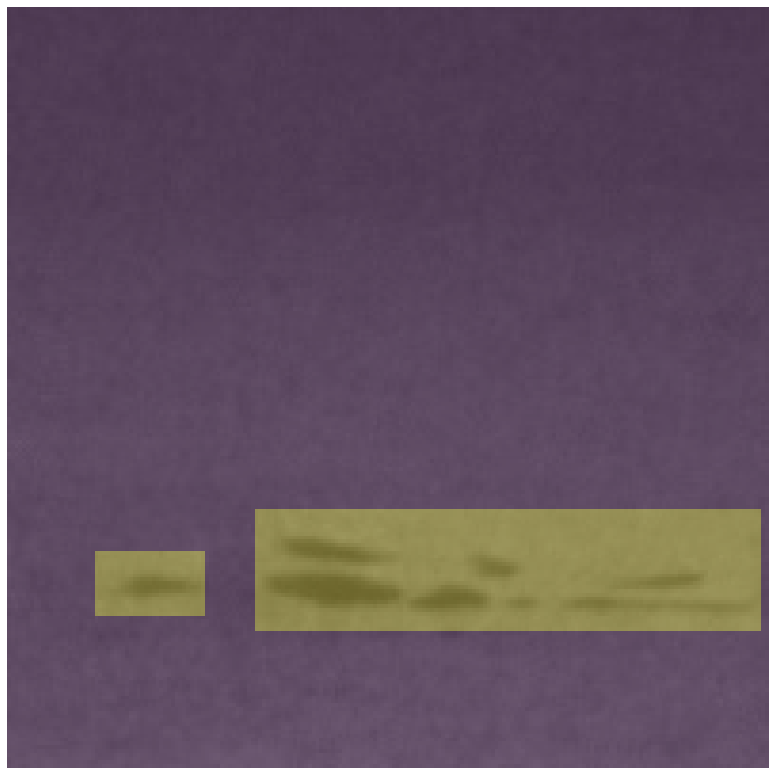

In [16]:
i = 7
object_val = df_obj.loc[i, 'obj']
show_obj(object_val, datafolder)

In [17]:
%%time

# for idx, row in tqdm(df_obj.iterrows()):
df_merge = {
    'obj': [],
    'w': [],
    'h': [],
    'd': [],
    'm_s': [],
}
for idx, row in tqdm(df_obj.iterrows()):

    img_shape, mask_size = get_stats(row['obj'], datafolder)
    df_merge['obj'].append(row['obj'])
    df_merge['w'].append(img_shape[0])
    df_merge['h'].append(img_shape[1])
    df_merge['d'].append(img_shape[2])
    df_merge['m_s'].append(mask_size)

df_merge = pd.DataFrame(df_merge)

df_stats = df_obj.merge(df_merge, on='obj', how='left')

df_stats['m_s_p'] = df_stats['m_s'] / (df_stats['w'] * df_stats['h']) 
display(df_stats.head())

0it [00:00, ?it/s]

,obj,type,id,w,h,d,m_s,m_s_p
0,inclusion_1,inclusion,1,200,200,3,3321.0,0.083025
1,inclusion_2,inclusion,2,200,200,3,1822.0,0.045550
2,inclusion_3,inclusion,3,200,200,3,3670.0,0.091750
3,inclusion_4,inclusion,4,200,200,3,3069.0,0.076725
4,inclusion_5,inclusion,5,200,200,3,3968.0,0.099200


CPU times: user 1.19 s, sys: 182 ms, total: 1.37 s
Wall time: 2.29 s


In [18]:
df_stats['type'].unique()

array(['inclusion', 'scratches'], dtype=object)

In [19]:
mask = df_stats['type'] == 'inclusion'
df_stats[mask].describe().drop(['count'], axis=0).drop(['id'], axis=1)

,w,h,d,m_s,m_s_p
mean,200.0,200.0,3.0,8971.279167,0.224282
std,0.0,0.0,0.0,4801.547188,0.120039
min,200.0,200.0,3.0,540.000000,0.013500
25%,200.0,200.0,3.0,5224.750000,0.130619
50%,200.0,200.0,3.0,8583.500000,0.214587
75%,200.0,200.0,3.0,11934.750000,0.298369
max,200.0,200.0,3.0,24098.000000,0.602450


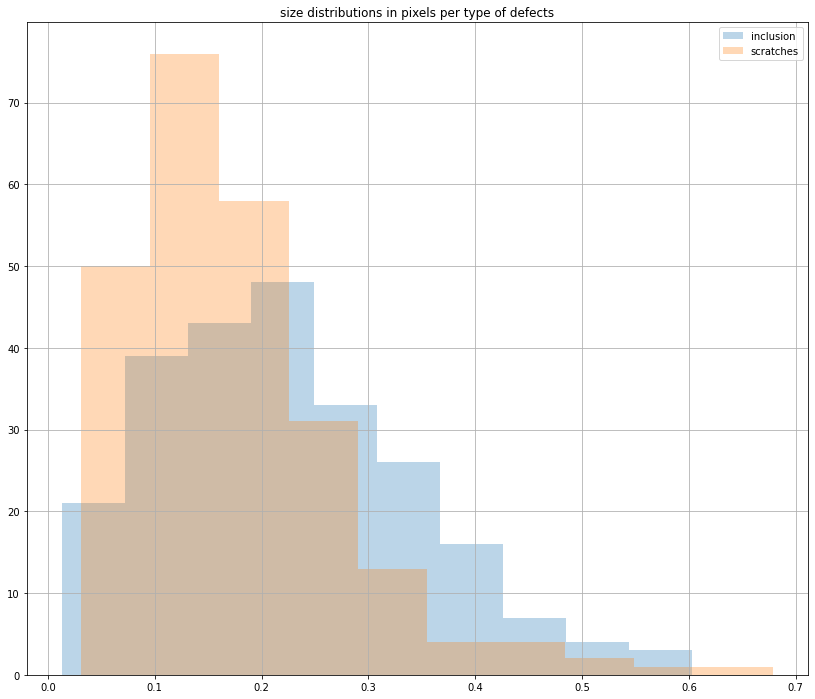

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
df_stats[mask]['m_s_p'].hist(ax=ax, alpha=0.3, label='inclusion')
df_stats[~mask]['m_s_p'].hist(ax=ax, alpha=0.3, label='scratches')
ax.set_title('size distributions in pixels per type of defects')
plt.legend();